<h1 align="center"> ** Data Mining** </h1>
<h2 align="center">  *1st Programming Assignment* </h2>
<h3 align="center">  Alex Karvouniaris </h3>

In [2]:
import pandas as pd
from bs4 import BeautifulSoup,SoupStrainer
import re
import time
import random
import os
import binascii
from collections import defaultdict

In [3]:
cd /Users/karvo/Desktop/aueb/Data Mining/assignment

C:\Users\karvo\Desktop\aueb\Data Mining\assignment


In [5]:
path =r'/Users/karvo/Desktop/aueb/Data Mining/assignment' 
ShingleSets=defaultdict(list)
#'shinglesSets' will hold the shingled set form of all the documents
# 'shinglesInDoc' will hold all of the unique shingle IDs present in the 
# current document. For this task we want to exploit the object-oriented 
#nature of python. The class set can check whether an object already exists in a set very quickly, 
#so this is the optimal way to go.
shinglesInDoc = set()
shortword = re.compile(r'\W*\b\w{1}\b') #catch low length words in order to skip them 

### Read all the files and store what we need in list
Below we mainly make use of BeautifulSoup to extract the body from each document, along with some extra functions that exploit regular expressions to create in the a neat form of our corpus.

In [6]:
article_id=0
list1=[]
articles=[]
for filename in os.listdir(path):
    if(filename.endswith(".sgm") ): #for the files that end with .sgm, a.k.a. our files
        print(filename)
        f = open(filename, 'r',encoding="utf-8",errors='ignore')
        data= f.read()
        soup = BeautifulSoup(data,'html.parser')
        contents = soup.findAll('body')
        #clean data from symbols and lower case all words
        for content in contents:
            articles.append(content)
            cont = " ".join(re.findall("[a-zA-Z]+", content.text))
            cont=cont.lower() #lower case everything
            cont=re.sub(' +',' ',cont)
            cont=shortword.sub('', cont)
            list1.append([cont])
        article_id=article_id+len(contents)

reut2-000.sgm
reut2-001.sgm
reut2-002.sgm
reut2-003.sgm
reut2-004.sgm
reut2-005.sgm
reut2-006.sgm
reut2-007.sgm
reut2-008.sgm
reut2-009.sgm
reut2-010.sgm
reut2-011.sgm
reut2-012.sgm
reut2-013.sgm
reut2-014.sgm
reut2-015.sgm
reut2-016.sgm
reut2-017.sgm
reut2-018.sgm
reut2-019.sgm
reut2-020.sgm
reut2-021.sgm


In [8]:
len(list1),list1[2]

(19043,
 ['texas commerce bancshares inc texas commerce bank houston said it filed an application with the comptroller of the currency in an effort to create the largest banking network in harris county the bank said the network would link banks having billion dlrs in assets and billion dlrs in deposits reuter'])

As it seems above, we end up having nearly 19k documents-articles. Below we split words for each document and we will use them to create k-shingles for each document. 

In [9]:
bl=[]
for kk in list1:
    for artcl in kk:
        words=artcl.split() #splitting each article in words
        sl=[]
        for wrd in words:
            sl.append(wrd)
        bl.append(sl) #This task is preliminary for k-Shingling procedure

Apart from just shingling, we map shingles to shingle ID's using crc32 hash. Below we showcase an example of how this works.

In [93]:
aux='Me Myself and I'
aux_2=aux.encode(encoding='UTF-8')
binascii.crc32(aux_2) & 0xffffffff

3094358405

## k-Shingling

In [97]:
ShingleSets=defaultdict(list)
shinglesInDoc = set()
def kshin(k):
    id=-1
    for sl in bl:
        id=id+1
        docNames.append(id)
        for i,val in enumerate(sl):
            if(i<len(sl)-k):#1st word of each k-shingle
                shingle=sl[i]
                for l in range(1,k):#adding to the shingle to reach length k
                    shingle=shingle +' '+sl[i+l]
                shingle = shingle.encode(encoding='UTF-8') #encoding 
                crc = binascii.crc32(shingle) & 0xffffffff#hashing
                shinglesInDoc.add(crc)
                ShingleSets[id].append(crc)
    return(ShingleSets)

In [98]:
kshin(3)

defaultdict(list,
            {0: [1110568442,
              3372193297,
              4016688963,
              3803533446,
              3042440262,
              1536478792,
              4108565609,
              3007321361,
              4107252027,
              2487608545,
              2921017891,
              271697306,
              3149268134,
              55402243,
              3473895120,
              4239806889,
              951647128,
              1672855470,
              2282551904,
              3196404569,
              3304154711,
              2460626165,
              571747070,
              1349983688,
              2200113398,
              2000411501,
              1121415109,
              3481645401,
              1874405023,
              2286423913,
              3716975886,
              1212555011,
              1819758315,
              892083753,
              1127006206,
              2066239542,
              924824124,
              94140329,


Now in order to create hash functions of the form $h(x)=(ax+b)modc$, at first we have to find the first prime that's greater than the total number of shingles. For this task, we just have to search for the first prime over the total number of values that 32-bit encoding can create, meaning $2^{32}-1$. We could easily implement some established technique for locating prime (e.g. Eratosthenes sieve), we will google this one since we are going to use the procedure only once and the solution of the problem is time-consuming in general. Then we have to generate hash functions, meaning coefficients a and b, in a way that no two hash functions have the same coefficients. 

In [99]:
maxShingleID=2**32 -1
nextPrime = 4294967311
totalNumberOfDocs=len(ShingleSets)

## Generate Hash Functions and MinHashing

In [103]:
def hashCoeffs(k):
    aux = []
    while(k>0):
        aux0 = random.randint(0, maxShingleID)  #exploiting numpy's random generators
        while( aux0 in aux): # all values in aux kept unique
            aux0 = random.randint(0, maxShingleID) 
        aux.append(aux0)
        k +=-1
    return aux

In [101]:
hashCoeffs(5)

[3307951602, 779994086, 2309565879, 844077165, 673829177]

In [104]:
def min_hashing(numHashes,numDocs): 
    coeffA = hashCoeffs(numHashes)
    coeffB = hashCoeffs(numHashes)
    signatures = []
    for docID in range(0,numDocs):
        shingleIDSet = ShingleSets[docID] 
        signature = []
        for i in range(0, numHashes): #for every hash function
            minHashValue = nextPrime + 1 #base value, equivalent to infinity cause of mod function
            for shingleID in shingleIDSet: #for every component of shingled document
                hash_value = (coeffA[i] * shingleID + coeffB[i]) % nextPrime #hash it
                if( hash_value < minHashValue):  #keep the minimum 
                    minHashValue = hash_value
            signature.append(minHashValue)
        signatures.append(signature)  
    return(signatures)

In [18]:
Sign_Matrix=min_hashing(3,30)

In [19]:
Sign_Matrix[29]# That's the resulting signature for document 29

[5652210, 19518033, 18053868]

# Computing Jaccard similarity

In [20]:
#Showcasing an example
aux1=[1,4,5,6,7,8,5]
aux2=[2,3,4,5,6,1]
def Jaccard_Similarity(a,b):
    INTER=len(set.intersection(set(a),set(b)))
    UN=len(set.union(set(a),set(b)))
    JAC=INTER/UN
    return JAC
Jaccard_Similarity(aux1,aux2)

0.5

In [21]:
Jaccard_Similarity(ShingleSets[0],ShingleSets[2]) #straight forwardly

0.0

In [183]:
Jaccard_Similarity(Sign_Matrix[0],Sign_Matrix[2]) #through min hashes

0.0

Below we will conduct 3 different experiments to point out some interesting properties.

# Computing effect of k (shingling) on mean Jaccard sim

Although the most accurate way to conduct experiments would be to measure something (like mean Jaccard similarity) by counting Jaccard similarity for every possible combination, the number of couples to be tested is $19.000^2$. It is clear that the straightforward way of checking things is prohibited as far as time is concerned. We could design sophisticated ways to construct consistent estimators, however, we chose to randomly pick a document and check its similarity against all others.

In [105]:
import numpy as np
random_index=int(np.random.randint(totalNumberOfDocs,size=1))
denom=totalNumberOfDocs-1

In [74]:
exp1_list=list()
for exp1 in range(1,30):
    ShingleSets=defaultdict(list)
    shinglesInDoc = set()
    kshin(exp1)
    Sign_Matrix=min_hashing(3,totalNumberOfDocs)
    sum=0.0
    for i in range(totalNumberOfDocs):
        if i!=random_index:
            sum+=Jaccard_Similarity(ShingleSets[i],ShingleSets[random_index])
    mean_sim=sum/denom      
    exp1_list.append(mean_sim)            

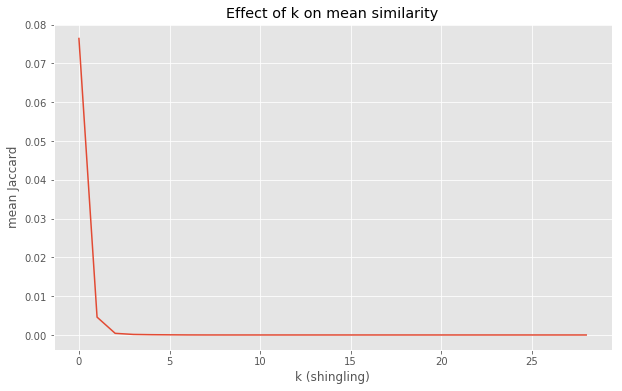

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.style.use('ggplot')
x = np.arange(0, 29)
plt.plot(x,exp1_list)
plt.xlabel('k (shingling)')
plt.ylabel('mean Jaccard')
plt.title('Effect of k on mean similarity')
plt.show()

As we could have guessed, the similarity is a decreasing function as k is increased. The probability of finding similarities between 2 documents if you 1-shingle is still high, whatever the real similarity between the documents, since both documents use the same language.

# Computing time difference between straightforward Jaccard similarity and minhashing way

In [76]:
ShingleSets=defaultdict(list)
shinglesInDoc = set()
kshin(3)
Sign_Matrix=min_hashing(10,totalNumberOfDocs)
t01=time.time()
for i in range(totalNumberOfDocs):
    if i!=random_index:
        Jaccard_Similarity(ShingleSets[i],ShingleSets[random_index])
t1_elapsed=time.time()-t01
t02=time.time()
for i in range(totalNumberOfDocs):
    if i!=random_index:
        Jaccard_Similarity(Sign_Matrix[i],Sign_Matrix[random_index])
t2_elapsed=time.time()-t02
print('\n Straightforward Jaccard similarity took ' +str(t1_elapsed) +'\n minhash took '+str(t2_elapsed))


 Straightforward Jaccard similarity took 0.5599856376647949
 minhash took 0.07316780090332031


We can easily point out that the time needed of minhash method is a different order of magnitude, compared to the straightforward one. The difference would be even bigger if we have checked the powerset of combinations for their similarity.

# Computing accuracy of minhash method for different number of hash functions

In [77]:
ShingleSets=defaultdict(list)
shinglesInDoc = set()
kshin(2)
exp3_list=list()
for num_hash_func in range(1,15):
    Sign_Matrix=min_hashing(num_hash_func,totalNumberOfDocs)
    dif=0.0
    for i in range(totalNumberOfDocs):
        if i!=random_index:
            sim1=Jaccard_Similarity(ShingleSets[i],ShingleSets[random_index])
            sim2=Jaccard_Similarity(Sign_Matrix[i],Sign_Matrix[random_index])
            dif+=sim1-sim2
    exp3_list.append(dif/denom)                    

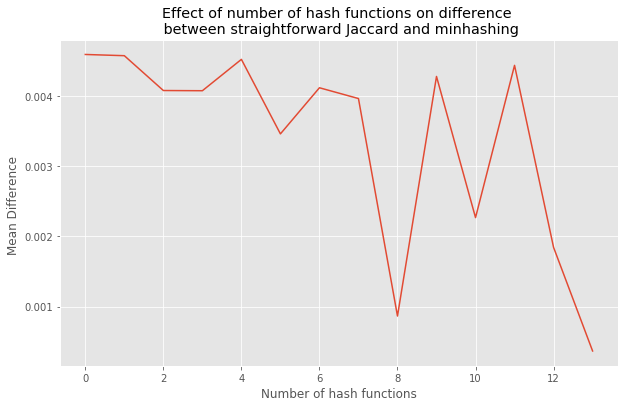

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.style.use('ggplot')
x = np.arange(0, 14)
plt.plot(x,exp3_list)
plt.xlabel('Number of hash functions')
plt.ylabel('Mean Difference ')
plt.title('Effect of number of hash functions on difference \n between straightforward Jaccard and minhashing')
plt.show()

Again, as we expected, as the number of hash functions used is increased the minhash Jaccard similarity converges to the real one. If we end up using too many, the results will be nearly identical, though our time-complexity gain will vanish too.